# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.053129,False,0.120828
1,-0.207370,True,4.094249
2,-1.275800,False,-0.859310
3,-0.514631,False,-0.044277
4,-0.492343,False,-1.173587
...,...,...,...
995,-1.726819,False,-1.129720
996,0.887459,True,6.021511
997,0.121581,False,0.815055
998,-0.055222,False,2.470749


<Axes: xlabel='v0'>

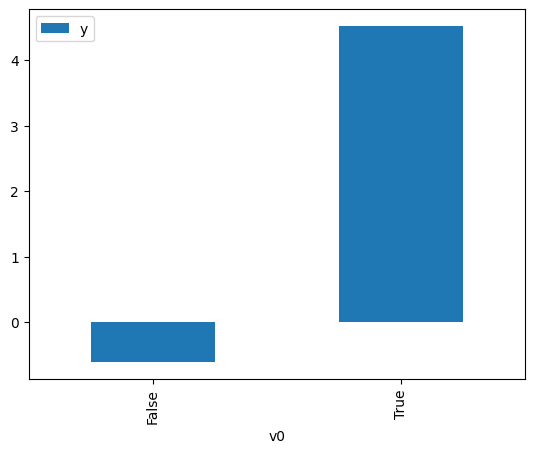

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

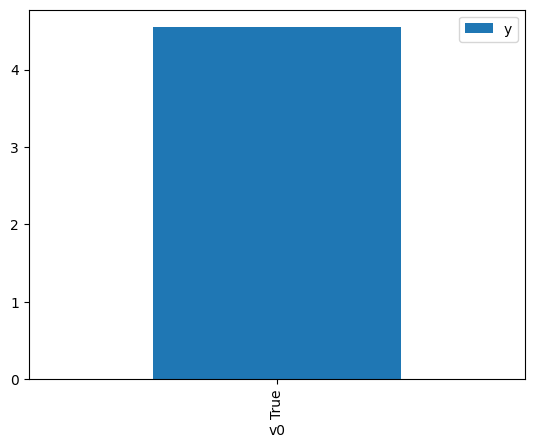

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.633871,False,1.312999,0.665605,1.502392
1,-0.175509,False,-1.165821,0.542828,1.842206
2,-1.078446,False,-0.447989,0.766648,1.304379
3,-0.314742,False,0.081439,0.581435,1.719882
4,-0.336533,False,-0.064835,0.587401,1.702416
...,...,...,...,...,...
995,0.040103,False,1.332026,0.482183,2.073901
996,-1.697978,False,-0.389464,0.868503,1.151406
997,-1.754553,False,-0.993133,0.875616,1.142053
998,-3.082791,False,-1.276667,0.969192,1.031787


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-2.138355,True,4.567015,0.084388,11.849986
1,-0.117730,True,5.781131,0.473374,2.112494
2,-1.467283,True,3.844971,0.164137,6.092457
3,-0.957786,True,6.387480,0.258558,3.867610
4,-0.880099,True,4.810873,0.275696,3.627186
...,...,...,...,...,...
995,-0.023319,True,5.155874,0.499953,2.000189
996,-0.767021,True,5.592769,0.301860,3.312796
997,-2.138355,True,4.567015,0.084388,11.849986
998,-1.057830,True,4.123990,0.237535,4.209913


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.890
Model:                            OLS   Adj. R-squared (uncentered):              0.889
Method:                 Least Squares   F-statistic:                              4019.
Date:                Thu, 17 Aug 2023   Prob (F-statistic):                        0.00
Time:                        13:49:18   Log-Likelihood:                         -1422.9
No. Observations:                1000   AIC:                                      2850.
Df Residuals:                     998   BIC:                                      2860.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6472      0.023     27.863      0.000       0.602       0.693
x2             5.0674      0.058     87.798      0.000       4.954       5.181
==============================================================================
Omnibus:                        6.808   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                6.753
Skew:                          -0.200   Prob(JB):                       0.0342
Kurtosis:                       3.051   Cond. No.                         2.51
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""